
https://github.com/Ahus-AIM/Open-ECG-Digitizer

https://arxiv.org/abs/2510.19590

No segmentation model parameters have been adapted to the kaggle training set.

No hyperparameters have been rigorously tuned on the kaggle training set (we just made sure it looked OK on folder no. 100642785).

# Imports

In [1]:
%cd /kaggle/input/open-ecg-digitizer/pytorch/default/1
import torch
import glob
import os.path
import yaml
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torchvision.io import read_image
from torch import Tensor
# Imports from https://github.com/Ahus-AIM/Open-ECG-Digitizer
from src.model.unet import UNet
from src.model.perspective_detector import PerspectiveDetector
from src.model.cropper import Cropper
from src.model.pixel_size_finder import PixelSizeFinder
from src.model.signal_extractor import SignalExtractor
from src.model.lead_identifier import LeadIdentifier
from src.model.lead_identifier import LeadIdentifier

/kaggle/input/open-ecg-digitizer/pytorch/default/1


# Hyperparameters - please optimize these using the training set!

Some descriptions of the modules: https://arxiv.org/abs/2510.19590

In [2]:
# Resample size: trade-off between accuracy and speed/vram
resample_size = 3000 # maximum no. pixels along the longest dimension

# PixelSizeFinder
PixelSizeFinderKwargs = dict(
    mm_between_grid_lines=5,
    samples=1000,
    min_number_of_grid_lines=20,
    max_number_of_grid_lines=100,
    max_zoom=10,
    zoom_factor=10.0,
    lower_grid_line_factor=0.1,
)

# SignalExtractor
SignalExtractorKwargs = dict(
    threshold_sum=10.0,
    threshold_line_in_mask=0.8,
    label_thresh=0.05,
    max_iterations=4,
    split_num_stripes=4,
    candidate_span=10,
    lam=0.5,
    min_line_width=30,
)

# PerspectiveDetector
PerspectiveDetectorKwargs = dict(
    num_thetas=200, # Higher -> more accurate but slower and more VRAM
    max_num_nonzero=10_000,
)

# LeadIdentifier
LeadIdentifierKwargs = dict(
    layouts=None,  # should be a dict[str, Any]
    unet=None,     # should be a torch.nn.Module
    device=None,   # should be a torch.device
    possibly_flipped=True,
    target_num_samples=None,
    required_valid_samples=2,
    debug=False,
)

# Cropper
CropperKwargs = dict(
    granularity=50,
    percentiles=(0.03, 0.97),
    alpha=0.95,
)

# Layout UNet (you CAN change this but then you need to retrain the net)
# https://github.com/Ahus-AIM/Open-ECG-Digitizer/blob/main/src/train.py
# https://github.com/Ahus-AIM/Open-ECG-Digitizer/blob/main/src/config/lead_name_unet.yml
LayoutUNetKwargs = dict(
    weights_path="/kaggle/input/open-ecg-digitizer-weights/pytorch/default/1/lead_name_unet_weights_07072025.pt",
    num_in_channels=1,
    num_out_channels=13,
    dims=[32, 64, 128, 256, 256],
    depth=2,
)

# Segmentation UNet (you CAN change this but then you need to retrain the net)
# https://github.com/Ahus-AIM/Open-ECG-Digitizer/blob/main/src/train.py
# https://github.com/Ahus-AIM/Open-ECG-Digitizer/blob/main/src/config/unet.yml
LoadModelKwargs = dict(
    weights_path="/kaggle/input/open-ecg-digitizer-weights/pytorch/default/1/unet_weights_07072025.pt",
    num_in_channels=3,
    num_out_channels=4,
    dims=[32, 64, 128, 256, 320, 320, 320, 320],
    depth=2,
)


# Utility code for plotting and orchestrating the modules

You can also use https://github.com/Ahus-AIM/Open-ECG-Digitizer/blob/main/src/model/inference_wrapper.py for orchestrating the modules if you want.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def add_noise_to_image(input_img, sigma=1.0, opacity=0.85):
    noise = torch.sigmoid(torch.randn_like(input_img) * sigma)
    input_img = (opacity)*input_img + (1-opacity) * noise
    return input_img

def load_model(**kwargs):
    weights_path = kwargs.pop("weights_path", None)  # safely extract
    model = UNet(**kwargs)
    state_dict = torch.load(weights_path, map_location=device)
    state_dict = {k.replace("_orig_mod.", ""): v for k, v in state_dict.items()}
    model.load_state_dict(state_dict)
    model.eval().to(device)
    return model


def load_png_file(path):
    img = read_image(path)
    img = img.float() / 255.0
    img = img.unsqueeze(0)
    if img.shape[1] > 3:
        img = img[:, :3, :, :]
    return img


def _crop_y(
    image: Tensor,
    signal_prob: Tensor,
    grid_prob: Tensor,
    text_prob: Tensor,
) -> tuple[Tensor, Tensor, Tensor, Tensor]:
    def get_bounds(tensor: Tensor) -> tuple[int, int]:
        prob = torch.clamp(
            tensor.squeeze().sum(dim=tensor.dim() - 3)
            - tensor.squeeze().sum(dim=tensor.dim() - 3).mean(),
            min=0,
        )
        non_zero = (prob > 0).nonzero(as_tuple=True)[0]
        if non_zero.numel() == 0:
            return 0, tensor.shape[2] - 1
        return int(non_zero[0].item()), int(non_zero[-1].item())

    y1, y2 = get_bounds(signal_prob + grid_prob)

    slices = (slice(None), slice(None), slice(y1, y2 + 1), slice(None))
    return (
        image[slices],
        signal_prob[slices],
        grid_prob[slices],
        text_prob[slices],
    )


def _align_feature_maps(
    cropper: Cropper,
    image: Tensor,
    signal_prob: Tensor,
    grid_prob: Tensor,
    text_prob: Tensor,
    source_points: Tensor,
) -> tuple[Tensor, Tensor, Tensor, Tensor]:
    aligned_signal_prob = cropper.apply_perspective(
        signal_prob,
        source_points,
        fill_value=0,
    )
    aligned_image = cropper.apply_perspective(
        image,
        source_points,
        fill_value=0,
    )
    aligned_grid_prob = cropper.apply_perspective(
        grid_prob,
        source_points,
        fill_value=0,
    )
    aligned_text_prob = cropper.apply_perspective(
        text_prob,
        source_points,
        fill_value=0,
    )
    (
        aligned_image,
        aligned_signal_prob,
        aligned_grid_prob,
        aligned_text_prob,
    ) = _crop_y(
        aligned_image,
        aligned_signal_prob,
        aligned_grid_prob,
        aligned_text_prob,
    )

    return (
        aligned_image,
        aligned_signal_prob,
        aligned_grid_prob,
        aligned_text_prob,
    )


def plot_segmentation_and_image(
    image,
    segmentation,
    aligned_signal,
    aligned_grid,
    lines,
):
    import matplotlib.pyplot as plt
    import numpy as np

    image_np = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    probs = segmentation.squeeze(0).cpu()

    show_featuremap = torch.ones(probs.shape[1], probs.shape[2], 3)
    probs[2] /= probs[2].max()
    show_featuremap[:, :, [0, 1, 2]] -= 2 * probs[2].unsqueeze(-1)
    show_featuremap[:, :, [1, 2]] -= probs[0].unsqueeze(-1)
    show_featuremap = torch.clamp(show_featuremap, 0, 1).numpy()

    straightened_featuremap = torch.ones(
        aligned_signal.shape[2],
        aligned_signal.shape[3],
        3,
        device=aligned_signal.device,
    )
    aligned_signal /= aligned_signal.max()
    straightened_featuremap[:, :, [0, 1, 2]] -= 2 * aligned_signal[0, 0].unsqueeze(-1)
    aligned_grid /= aligned_grid.max()
    straightened_featuremap[:, :, [1, 2]] -= aligned_grid[0, 0].unsqueeze(-1)
    straightened_featuremap = torch.clamp(straightened_featuremap, 0, 1)

    fig, ax = plt.subplots(2, 2, figsize=(16, 12))
    ax[0, 0].imshow(image_np)
    ax[0, 0].axis("off")

    ax[0, 1].imshow(show_featuremap)
    ax[0, 1].axis("off")

    ax[1, 0].imshow(straightened_featuremap.cpu())
    ax[1, 0].axis("off")

    offsets = [-0, -10.5, -7, -0, -3.5, -7, -0, -3.5, -7, -0, -3.5, -7]
    if lines.numel() > 0:
        ax[1, 1].plot(lines.T.cpu().numpy() + offsets[: lines.shape[0]])
    ax[1, 1].axis("off")
    plt.tight_layout()
    plt.show()


def crop_image(image, probs):
    perspective_detector = PerspectiveDetector(**PerspectiveDetectorKwargs)

    cropper = Cropper(**CropperKwargs)

    alignment_params = perspective_detector(probs[0, 0])

    source_points = cropper(probs[0, 1], alignment_params)

    signal_prob, grid_prob, text_prob = (
        probs[:, [2]],
        probs[:, [0]],
        probs[:, [1]],
    )

    (
        aligned_image,
        aligned_signal_prob,
        aligned_grid_prob,
        aligned_text_prob,
    ) = _align_feature_maps(
        cropper,
        image,
        signal_prob,
        grid_prob,
        text_prob,
        source_points,
    )

    return (
        aligned_image,
        aligned_signal_prob,
        aligned_grid_prob,
        aligned_text_prob,
    )


def extract_signals(
    aligned_signal_prob: Tensor,
    aligned_grid_prob: Tensor,
    aligned_text_prob: Tensor,
    target_num_samples: int,
) -> Tensor:
    pixel_size_finder = PixelSizeFinder(**PixelSizeFinderKwargs)
    signal_extractor = SignalExtractor(**SignalExtractorKwargs)

    layout_unet = load_model(
        **LayoutUNetKwargs,
    )

    layouts = yaml.safe_load(
        open("src/config/lead_layouts_george-moody-2024.yml", "r"),
    )

    identifier_kwargs = LeadIdentifierKwargs.copy()
    identifier_kwargs.update(
        dict(
            layouts=layouts,
            unet=layout_unet,
            device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
            target_num_samples=target_num_samples,
        )
    )
    identifier = LeadIdentifier(**identifier_kwargs)
    mm_per_pixel_x, mm_per_pixel_y = pixel_size_finder(aligned_grid_prob)

    avg_pixel_per_mm = (1 / mm_per_pixel_x + 1 / mm_per_pixel_y) / 2 # Is there a better way?
    signals = signal_extractor(aligned_signal_prob.squeeze())
    
    signals = identifier(
        signals,
        aligned_text_prob,
        avg_pixel_per_mm=avg_pixel_per_mm,
    )

    return signals

def resample_image(image: Tensor, resample_size: int) -> Tensor:
    height, width = image.shape[2], image.shape[3]
    min_dim = min(height, width)
    max_dim = max(height, width)

    if isinstance(resample_size, int):
        if max_dim > resample_size:
            scale = resample_size / max_dim
            new_size = (int(height * scale), int(width * scale))
            return F.interpolate(image, size=new_size, mode="bilinear", align_corners=False, antialias=True)
        return image

    if isinstance(resample_size, tuple):
        interpolated = F.interpolate(
            image, size=resample_size, mode="bilinear", align_corners=False, antialias=True
        )
        return interpolated

    raise ValueError(f"Invalid resample_size: {resample_size}. Expected int or tuple of (height, width).")

leads_names = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
def get_slice(lead_name: str, number_of_rows: int) -> slice:
    assert lead_name in leads_names
    if lead_name in ("II",):
        return slice(0, number_of_rows)
    if lead_name in (("I", "III")):
        return slice(0, number_of_rows)
    if lead_name in (("aVR", "aVF", "aVL")):
        return slice(1*number_of_rows, 2*number_of_rows)
    if lead_name in (("V1", "V2", "V3")):
        return slice(2*number_of_rows, 3*number_of_rows)
    if lead_name in (("V4", "V5", "V6")):
        return slice(3*number_of_rows, 4*number_of_rows)

def digitize_image(input_img: Tensor, resample_size: int, target_num_samples: int) -> Tensor:
    input_img = add_noise_to_image(input_img) # The UNet is trained for "real" images. Sometimes it performs better with added noise for generated images.
    input_img = resample_image(image=input_img, resample_size=resample_size) # higher resample size is (probably) better but watch out for VRAM and time consraints
    
    with torch.no_grad():
        logits = model(input_img.to(device))
        output_probs = torch.softmax(logits, dim=1)
        aligned_image, aligned_signal, aligned_grid, aligned_text = crop_image(input_img, output_probs)
        lines = extract_signals(aligned_signal, aligned_grid, aligned_text, target_num_samples=target_num_samples)
        lines = lines["canonical_lines"] * 1e-3  # microvolt to millivolt

    return output_probs, aligned_signal, aligned_grid, lines.float()
    

model = load_model(**LoadModelKwargs)

# Visualize a few example images.

Segmenting /kaggle/input/physionet-ecg-image-digitization/train/1006427285/1006427285-0004.png...


Segmenting /kaggle/input/physionet-ecg-image-digitization/train/1006427285/1006427285-0005.png...


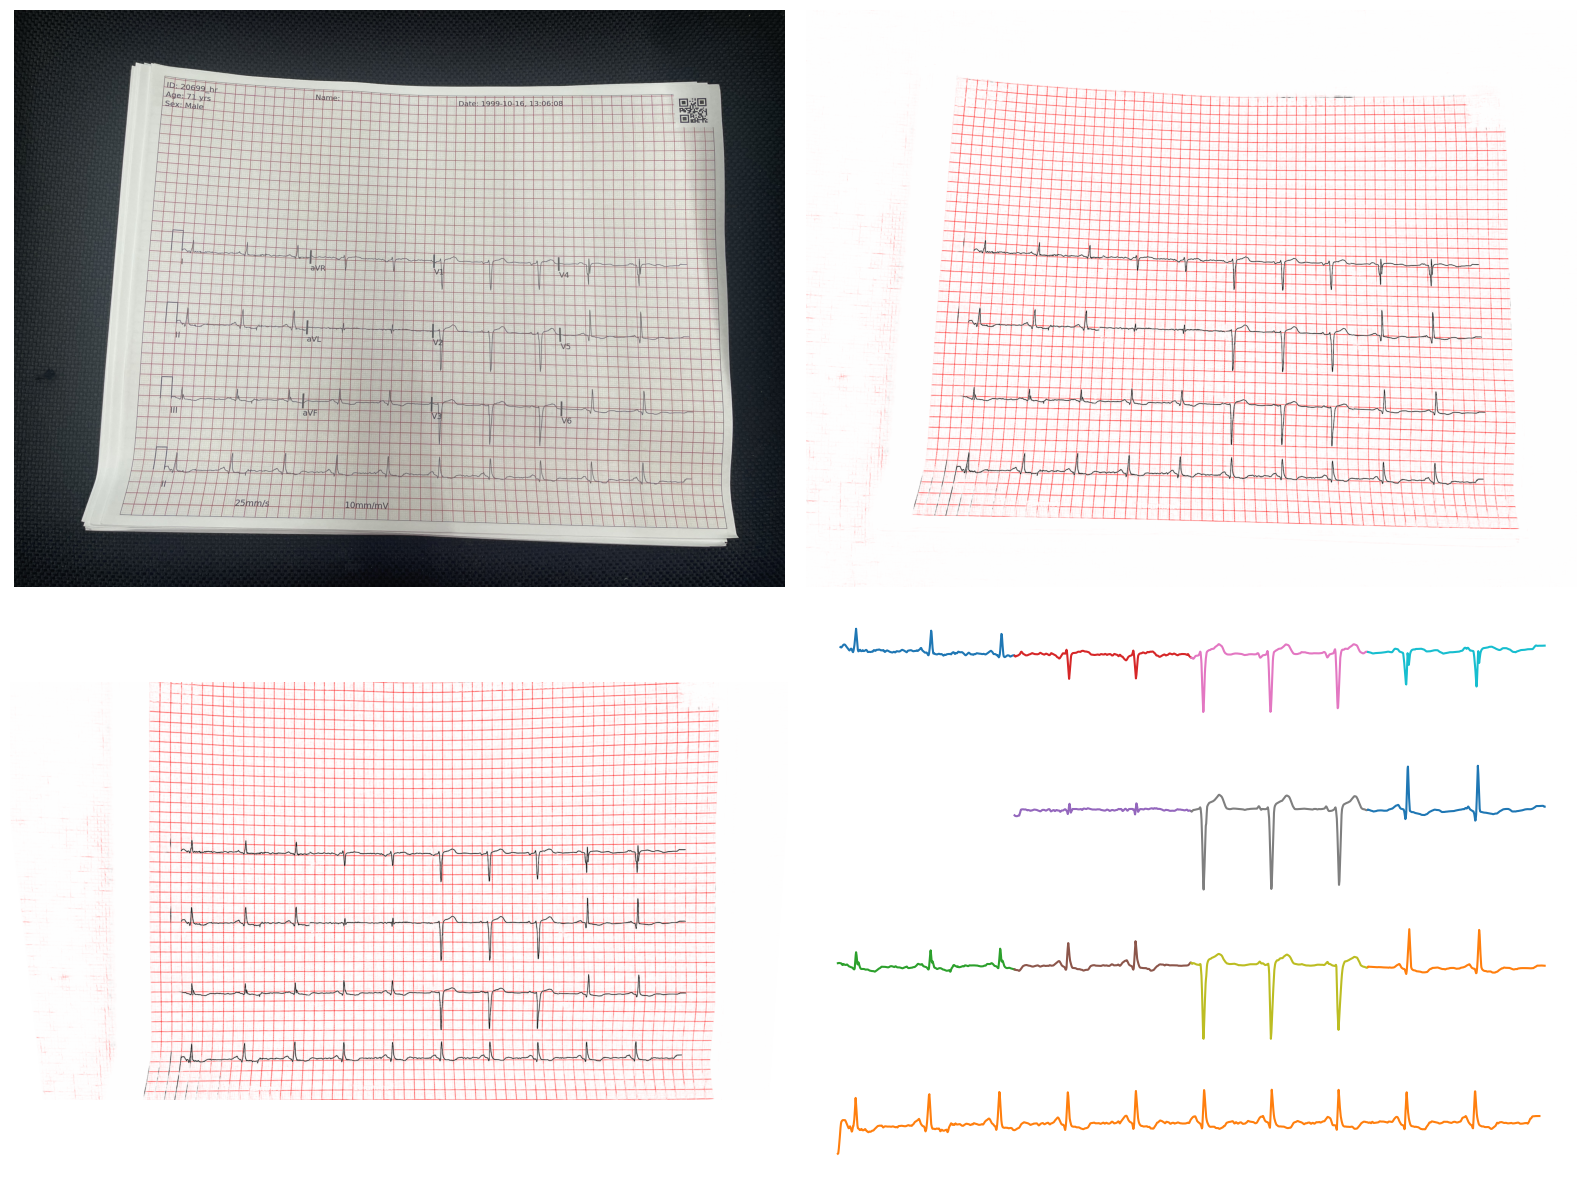

Segmenting /kaggle/input/physionet-ecg-image-digitization/train/1006427285/1006427285-0006.png...


In [4]:
paths = [
    "/kaggle/input/physionet-ecg-image-digitization/train/1006427285/1006427285-0004.png",
    "/kaggle/input/physionet-ecg-image-digitization/train/1006427285/1006427285-0005.png",
    "/kaggle/input/physionet-ecg-image-digitization/train/1006427285/1006427285-0006.png",
]

for path in paths:
    input_img = load_png_file(path)
    if not os.path.exists(path):
        continue

    ### SIGNAL EXTRACTION ###
    print(f"Segmenting {path}...")
    output_probs, aligned_signal, aligned_grid, lines = digitize_image(input_img, 2500, 10000)
    plot_segmentation_and_image(input_img, output_probs, aligned_signal, aligned_grid, lines)


# Run the digitization

In [5]:
test = pd.read_csv('/kaggle/input/physionet-ecg-image-digitization/test.csv')
output_path = '/kaggle/working/submission.csv'

# Prepare the file (write header once)
if os.path.exists(output_path):
    os.remove(output_path)
pd.DataFrame(columns=["id", "value"]).to_csv(output_path, index=False)

old_id = None

for index, row in test.iterrows():
    if row.id != old_id:
        old_id = row.id
    
        path = f"/kaggle/input/physionet-ecg-image-digitization/test/{row.id}.png"
        target_num_samples = row.fs * 10 # We assume 10 second signals, not optimal.
        input_img = load_png_file(path)

        ### SIGNAL EXTRACTION ###
        print(f"Segmenting {path}...")
        output_probs, aligned_signal, aligned_grid, lines = digitize_image(input_img, resample_size, target_num_samples)

        ### (optional) VISUALIZATION ###
        if False:
            plot_segmentation_and_image(input_img, output_probs, aligned_signal, aligned_grid, lines)

    ### SAVING ###
    file_id = row.id
    lead_name = row.lead
    number_of_rows_in_lead = row.number_of_rows

    index = leads_names.index(lead_name)

    lead_data = lines[index]
    lead_data = lead_data[get_slice(lead_name, number_of_rows_in_lead)]
    
    mean_val = np.nanmean(lead_data)
    if np.isnan(mean_val):
        mean_val = 0.0
    lead_data = np.nan_to_num(lead_data, nan=mean_val)

    assert len(lead_data) == number_of_rows_in_lead
    
    chunk = []
    for t in range(number_of_rows_in_lead):
        chunk.append({"id": f"{file_id}_{t}_{lead_name}", "value": float(lead_data[t])})

    if chunk:
        pd.DataFrame(chunk).to_csv(output_path, mode='a', index=False, header=False)

Segmenting /kaggle/input/physionet-ecg-image-digitization/test/1053922973.png...
Segmenting /kaggle/input/physionet-ecg-image-digitization/test/2352854581.png...


In [6]:
import pandas as pd

In [7]:
pd.read_csv("/kaggle/working/submission.csv")

id     value
0          1053922973_0_I -0.019146
1          1053922973_1_I -0.019146
2          1053922973_2_I -0.019146
3          1053922973_3_I -0.019146
4          1053922973_4_I -0.019146
...                   ...       ...
74995  2352854581_2495_V6 -0.347236
74996  2352854581_2496_V6 -0.346807
74997  2352854581_2497_V6 -0.346379
74998  2352854581_2498_V6 -0.345950
74999  2352854581_2499_V6 -0.345522

[75000 rows x 2 columns]